# Import Libraries

In [2]:
# System and File Operations
import glob
import os
import tarfile

# Image Processing
from PIL import Image
import matplotlib.pyplot as plt

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Timm Library for Transformer Model Architecture
import timm

# Google Colab
from google.colab import drive
drive.mount('/content/drive')
image_directory = '/content/extracted_data/Huron_Unlabeled_Data/'


Mounted at /content/drive


<H1> Extracting Unlabelled Data From .tar.xz file </H1>

In [3]:
tar_file_path = '/content/drive/My Drive/huron_unlabeled_data.tar.xz'
extract_to_path = '/content/extracted_data'

def extract_tar_xz(tar_file_path, extract_to_path):
    """
    Extracts the contents of a .tar.xz file to a specified directory.

    Input:
    - tar_file_path (str): The path to the .tar.xz archive file to be extracted.
    - extract_to_path (str): The directory path where the contents will be extracted.

    Output:
    - None: The function performs an extraction operation and does not return a value.
    """

    # Creates the specified directory if it doesn't already exist
    os.makedirs(extract_to_path, exist_ok=True)

    # Opens the specified .tar.xz file in read mode
    with tarfile.open(tar_file_path, 'r:xz') as tar:
        print("Extracting files...")

        # Extracts all files from the .tar.xz archive to the specified directory
        tar.extractall(path=extract_to_path)

        print("Extraction completed successfully!")

extract_tar_xz(tar_file_path, extract_to_path)

Extracting files...
Extraction completed successfully!


# Creating Unlabeled Dataset Class
## Creates

In [4]:
# Custom Dataset for Unlabeled Images
class UnlabeledDataset(Dataset):
    def __init__(self, image_dir, global_transform=None, local_transform=None, num_global_views=2, num_local_views=4):
        """
        Initializes the UnlabeledDataset.

        Input:
        - image_dir (str): The directory containing the image files.
        - global_transform (callable, optional): Transformations applied to generate global views.
        - local_transform (callable, optional): Transformations applied to generate local views.
        - num_global_views (int): Number of global views per image.
        - num_local_views (int): Number of local views per image.

        Output:
        - None: This initializer sets up attributes needed to handle the dataset.
        """

        # Initialize the image directory and retrieve image files
        self.image_dir = image_dir
        self.image_files = glob.glob(os.path.join(image_dir, '**', '*'), recursive=True)

        # Check if any image files were found, otherwise print a warning
        if not self.image_files:
            print("No image files found. Check the extraction path and file extensions.")
        else:
            print(f"Number of images found: {len(self.image_files)}")

        # Store the transformations and number of views
        self.global_transform = global_transform
        self.local_transform = local_transform
        self.num_global_views = num_global_views
        self.num_local_views = num_local_views

    def __len__(self):

        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Retrieves an image and applies transformations to create multiple views.

        Input:
        - idx (int): Index of the image in the dataset.

        Output:
        - list: A list of augmented views for the specified image.
        """

        # Get the path for the image at the specified index
        img_path = self.image_files[idx]

        # Try to open the image, skipping it if an error occurs
        try:
            image = Image.open(img_path).convert('RGB')
        except (FileNotFoundError, OSError) as e:
            print(f"Error loading image at {img_path}: {e}")
            return None  # Return None if an error occurs

        # Generate multiple augmented views of the image
        views = []

        # Apply global transformations
        for _ in range(self.num_global_views):
            if self.global_transform:
                views.append(self.global_transform(image))

        # Apply local transformations
        for _ in range(self.num_local_views):
            if self.local_transform:
                views.append(self.local_transform(image))

        return views  # Return a list of augmented views


# Create the **Global** and **Local** Transformations

In [5]:
mean = [0.8786, 0.8474, 0.8732]
std = [0.2504, 0.2687, 0.2513]

global_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Maintain most of the tissue.
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.8, contrast=1.1, saturation=0.9, hue=0.02)], p=0.8),
    transforms.RandomRotation(degrees=10),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

local_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),  # Ensures minimum context of half the image
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.8, contrast=1.1, saturation=0.9, hue=0.02)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.3),  # Mild blur to avoid distortion
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])



# Creating the dataset with the **2** global views and **4** local views.  

In [6]:
dataset = UnlabeledDataset(
    image_dir=image_directory,
    global_transform=global_transforms,
    local_transform=local_transforms,
    num_global_views=2,  # Adjust as needed
    num_local_views=4    # Adjust as needed
)

data_loader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0, drop_last=True)


Number of images found: 16352


# Visualize an example and it's transformations

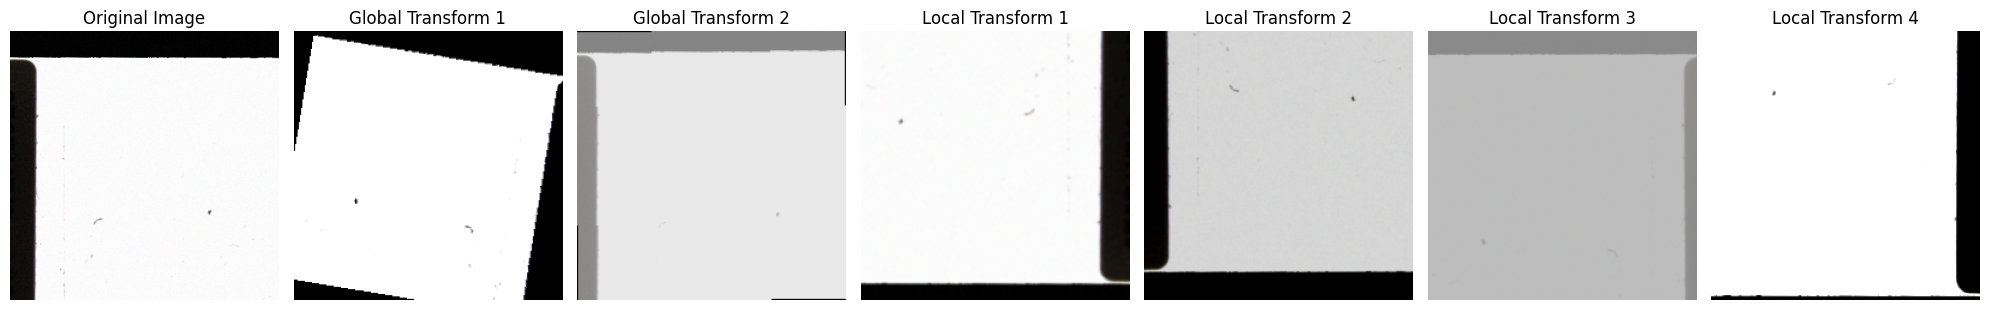

In [ ]:
# Get a sample image from the dataset, including the original image
original_image = dataset.image_files[2]  # Path to the original image at index 4
views = dataset[2]  # List of transformed views generated from the dataset

# Helper function to denormalize and convert a tensor to a displayable format
def denormalize(tensor, mean, std):
    """
    Denormalizes a tensor by reversing the normalization process.

    Input:
    - tensor: A normalized image tensor.
    - mean: List of means used for normalization
    - std: List of standard deviations used for normalization
    Output:
    - tensor: The denormalized tensor.
    """
    tensor = tensor.clone()  # Clone tensor to avoid modifying the original
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Denormalize by multiplying by std and adding mean
    return tensor

def tensor_to_image(tensor, mean, std):
    """
    Converts a denormalized tensor to a PIL image.

    Input:
    - tensor: A normalized image tensor.
    - mean: List of means used for normalization.
    - std: List of standard deviations used for normalization.

    Output:
    - A PIL image that can be displayed.
    """
    tensor = denormalize(tensor, mean, std)  # Denormalize the tensor
    tensor = torch.clamp(tensor, 0, 1)  # Clip values to [0, 1] range for display
    return transforms.ToPILImage()(tensor)  # Convert tensor to PIL image

# Display the original and transformed images
plt.figure(figsize=(20, 5))

# Display the original image
plt.subplot(1, len(views) + 1, 1)  # Add space for the original image
original_image = Image.open(original_image).convert('RGB')  # Open the original image
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

# Display global transformations
num_global_views = 2  # Number of global views generated per image
num_local_views = len(views) - num_global_views  # Calculate the number of local views

# Loop to display each global view
for i in range(num_global_views):
    plt.subplot(1, len(views) + 1, i + 2)  # Shift indices to accommodate the original image
    plt.imshow(tensor_to_image(views[i], mean, std))
    plt.title(f"Global Transform {i + 1}")
    plt.axis('off')

# Loop to display each local view
for i in range(num_global_views, len(views)):
    plt.subplot(1, len(views) + 1, i + 2)
    plt.imshow(tensor_to_image(views[i], mean, std))
    plt.title(f"Local Transform {i - num_global_views + 1}")
    plt.axis('off')

plt.tight_layout()  # Adjust layout for clear spacing
plt.show()


#DINO Head class

In [ ]:
# DINO Head module for projection and normalization in Self-Supervised Learning
class DINOHead(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=2048, bottleneck_dim=256):
        """
        Initializes the DINOHead projection layer.

        Input:
        - in_dim (int): Input dimension size.
        - out_dim (int): Projection dimension size for the DINO head (not the number of classes).
        - hidden_dim (int, optional): Dimension of the hidden layer (default is 2048).
        - bottleneck_dim (int, optional): Dimension of the bottleneck layer (default is 256).

        Output:
        - None: This initializer sets up the multi-layer perceptron (MLP) and last layer for the DINO Head.
        """
        super(DINOHead, self).__init__()

        # Multi-layer perceptron (MLP) with GELU activation
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),      # First linear layer for input to hidden dimension
            nn.GELU(),                          # GELU activation for non-linearity
            nn.Linear(hidden_dim, bottleneck_dim)  # Second linear layer for hidden to bottleneck dimension
        )

        # Last layer with weight normalization
        # Projects the bottleneck dimension to the output dimension
        self.last_layer = nn.utils.weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))

    def forward(self, x):

        # Apply the MLP to the input
        x = self.mlp(x)

        # Normalize the output of the MLP
        x = F.normalize(x, dim=-1, p=2)

        # Pass the normalized output through the last projection layer
        return self.last_layer(x)


#DINO Loss Class

In [ ]:
# DINO Loss class for calculating self-supervised learning loss
class DINOLoss(nn.Module):
    def __init__(self, out_dim, ncrops, warmup_teacher_temp, teacher_temp, warmup_teacher_temp_epochs, nepochs, student_temp=0.1, center_momentum=0.9):
        """
        Initializes the DINOLoss module.

        Input:
        - out_dim (int): Dimension of the output space.
        - ncrops (int): Number of crops/views used for DINO.
        - warmup_teacher_temp (float): Initial temperature for the teacher's softmax during warm-up.
        - teacher_temp (float): Final temperature for the teacher's softmax after warm-up.
        - warmup_teacher_temp_epochs (int): Number of epochs over which to increase teacher temperature.
        - nepochs (int): Total number of epochs for training.
        - student_temp (float, optional): Temperature for the student's softmax (default is 0.1).
        - center_momentum (float, optional): Momentum for updating the center (default is 0.9).

        Output:
        - None: Initializes the loss components including the teacher temperature schedule and center buffer.
        """
        super(DINOLoss, self).__init__()
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.ncrops = ncrops

        # Initialize the center buffer (for teacher output centering) to zero with the specified output dimension
        self.register_buffer("center", torch.zeros(1, out_dim))

        # Create a schedule for the teacher's temperature over training epochs
        self.teacher_temp_schedule = torch.cat((
            torch.linspace(warmup_teacher_temp, teacher_temp, warmup_teacher_temp_epochs),
            torch.ones(nepochs - warmup_teacher_temp_epochs) * teacher_temp
        ))

    def forward(self, student_output, teacher_output, epoch):
        """
        Computes the DINO loss for a given batch.

        Input:
        - student_output (tensor): Output logits from the student network.
        - teacher_output (tensor): Output logits from the teacher network.
        - epoch (int): Current epoch, used to select the appropriate temperature for the teacher.

        Output:
        - Tensor representing the DINO loss for the current batch.
        """
        # Ensure the center and temperature schedule are on the same device as the student output
        device = student_output.device
        self.center = self.center.to(device)
        temp = self.teacher_temp_schedule[epoch].to(device)

        # Normalize and split the student output across crops
        student_out = student_output / self.student_temp
        student_out = torch.chunk(student_out, self.ncrops)

        # Normalize, center, and split the teacher output across crops
        teacher_out = F.softmax((teacher_output - self.center) / temp, dim=-1)
        teacher_out = teacher_out.detach().chunk(self.ncrops)

        # Compute the DINO loss by calculating cross-entropy loss between student and teacher predictions
        total_loss = sum(
            torch.sum(-q * F.log_softmax(student_out[v], dim=-1), dim=-1).mean()
            for iq, q in enumerate(teacher_out)
            for v in range(len(student_out))
            if v != iq  # Ensure each crop is compared only with other crops, not itself
        )

        # Normalize the total loss by the number of terms
        n_loss_terms = self.ncrops * (self.ncrops - 1)
        return total_loss / n_loss_terms

    @torch.no_grad()
    def update_center(self, teacher_output):
        """
        Updates the center used for teacher output centering.

        Input:
        - teacher_output (tensor): Output from the teacher network, used to compute the new center.

        Output:
        - None: Updates the center buffer in place with momentum.
        """
        # Compute the batch mean for teacher outputs
        batch_center = teacher_output.mean(dim=0, keepdim=True)

        # Update the center with momentum
        self.center.mul_(self.center_momentum).add_(batch_center * (1 - self.center_momentum))


#Model Initialization
# ViT Base Patch 16 224



In [ ]:
# Create the base (student) model with DINO head
base_model = timm.create_model('vit_base_patch16_224', pretrained=False)
in_dim = base_model.head.in_features
base_model.head = DINOHead(in_dim, out_dim=8192)

# Checkpoint for epochs. Leave None to start from epoch 1
#checkpoint_path = '/base_model_epoch_1.pth'

# Load checkpoint if path is specified
#if checkpoint_path:
    #base_model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

# Create the teacher model with DINO head
teacher_model = timm.create_model('vit_base_patch16_224', pretrained=False)
teacher_in_dim = teacher_model.head.in_features  # Use in_dim of teacher model directly
teacher_model.head = DINOHead(teacher_in_dim, out_dim=8192)
teacher_model.load_state_dict(base_model.state_dict())  # Initialize teacher with student weights
teacher_model.eval()

# Freeze teacher model parameters
for param in teacher_model.parameters():
    param.requires_grad = False

# Move models to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)
teacher_model.to(device)


#Training Loop

In [ ]:
# Optimizer setup for the base model with AdamW
optimizer = optim.AdamW(base_model.parameters(), lr=0.001, weight_decay=0.05)

# Set number of training epochs
num_epochs = 10

# Initialize the DINO loss function with centering and temperature schedules
dino_loss_fn = DINOLoss(
    out_dim=8192,                   # Dimension of output features
    ncrops=8,                       # Number of crops/views for DINO
    warmup_teacher_temp=0.04,       # Initial temperature for teacher during warm-up
    teacher_temp=0.07,              # Final temperature for teacher after warm-up
    warmup_teacher_temp_epochs=5,   # Warm-up period for teacher temperature
    nepochs=num_epochs,             # Total number of training epochs
    student_temp=0.1,               # Temperature for student outputs
    center_momentum=0.9             # Momentum for updating the center buffer
).to(device)

# Directory for saving model checkpoints
checkpoint_dir = '/content/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Training loop over epochs
for epoch in range(num_epochs):
    base_model.train()  # Set model to training mode
    total_loss = 0.0
    print(f"\nStarting epoch {epoch + 1}/{num_epochs}...")

    # Loop over each batch in the data loader
    for i, images in enumerate(data_loader):
        images = [img.to(device) for img in images]  # Move images to device (e.g., GPU)

        # Forward pass through the student model for each view
        student_outputs = [base_model(img) for img in images]
        student_output = torch.cat(student_outputs)  # Concatenate outputs for DINO loss calculation

        # Forward pass through the teacher model without gradient computation
        with torch.no_grad():
            teacher_outputs = [teacher_model(img) for img in images]
            teacher_output = torch.cat(teacher_outputs)  # Concatenate teacher outputs

        # Calculate DINO loss using the student and teacher outputs
        loss = dino_loss_fn(student_output, teacher_output, epoch)

        # Backpropagation and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Exponential Moving Average (EMA) update for teacher model parameters
        with torch.no_grad():
            for teacher_param, student_param in zip(teacher_model.parameters(), base_model.parameters()):
                teacher_param.data.mul_(0.996).add_((1 - 0.996) * student_param.data)

        # Accumulate and display batch loss
        total_loss += loss.item()
        print(f"Batch {i + 1}, Loss: {loss.item():.4f}")

    # Calculate and print the average loss for the epoch
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    # Save model checkpoint at the end of each epoch
    checkpoint_path = os.path.join(checkpoint_dir, f"base_model_epoch_{epoch + 1}.pth")
    torch.save(base_model.state_dict(), checkpoint_path)
    print(f"Model weights saved to {checkpoint_path}")


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Number of images found: 16352


<ipython-input-40-afabee934a3d>:56: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], s=5, cmap='viridis')


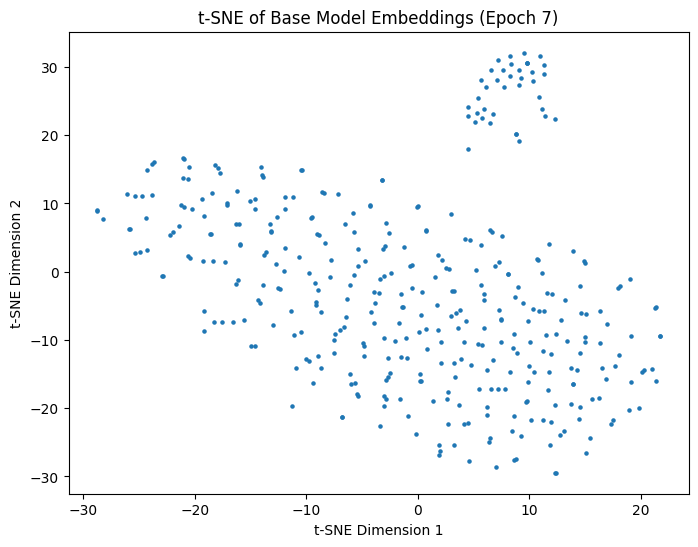

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import timm
# Load the base model and checkpoint
base_model = timm.create_model('vit_base_patch16_224', pretrained=False)
in_dim = base_model.head.in_features
base_model.head = DINOHead(in_dim, out_dim=8192)

# Load the saved checkpoint
checkpoint_path = './new_base_model_epoch_7.pth'
base_model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
base_model.eval()

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)

# Prepare the dataset and dataloader
image_dir = extract_to_path  # Path where images were extracted
dataset = UnlabeledDataset(
    image_dir="/content/extracted_data/Huron_Unlabeled_Data/",
    global_transform=global_transforms,
    local_transform=local_transforms,
    num_global_views=2,
    num_local_views=4
)
data_loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=0)

# Extract embeddings from a single batch of images for t-SNE
embeddings = []
with torch.no_grad():
    for i, images in enumerate(data_loader):
        if i == 1:  # Only get embeddings from the first batch to limit data size
            break
        images = [img.to(device) for img in images]
        batch_embeddings = [base_model(img).cpu().numpy() for img in images]
        embeddings.append(np.concatenate(batch_embeddings, axis=0))

# Concatenate embeddings for t-SNE
embeddings = np.concatenate(embeddings, axis=0)

# Scale embeddings before t-SNE
scaler = MinMaxScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=40, learning_rate=1000, max_iter=3000)
embeddings_tsne = tsne.fit_transform(embeddings_scaled)

# Plot t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], s=5, cmap='viridis')
plt.title('t-SNE of Base Model Embeddings (Epoch 7)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()